## TF-IDF를 이용한 핵심어 추출
- 형태소 추출하기
    - 한글 텍스트로 전처리
    - 형태소 단위로 추출
- 분류 모델의 학습 데이터로 변환
    - corpus index 생성
    - TF-IDF로 변환

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [28]:
import re
from konlpy.tag import Okt

# 한글만 추출
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

# 형태소 단위로 추출
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word, tag) for word, tag in pos]
    return pos


In [45]:
df = pd.read_csv("review_data.csv")

# 한글만 추출
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(str(x)))
del df['review']
df = df[df['ko_text'].str.len() > 0]

# 형태소 단위로 추출
result = get_pos(df['ko_text'].values[0])
print(result)

['맛있었어요/Adjective', '콩나물/Noun', '엄청/Adverb', '좋아해서/Adjective', '많이/Adverb', '먹었는데도/Verb', '많이/Adverb', '남았어요/Verb', '조금/Noun', '아까웠/Adjective', '슴/Noun', 'ㅠㅠ/KoreanParticle', '남은건/Verb', '포장/Noun', '도/Josa', '되서/Verb', '너무/Adverb', '좋았습니다/Adjective', '다음/Noun', '엔/Josa', '불고기/Noun', '먹으러/Verb', '가고싶어요/Verb', '너무/Adverb', '맛있게/Adjective', '잘/Verb', '먹었/Verb', '습/Noun', '니당/Verb']


In [109]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 형태소를 벡터 형태의 학습 데이터셋으로 변환
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x)) # 형태소 분리
X = index_vectorizer.fit_transform(df['ko_text'].to_list()) # 형태소 분리한 말뭉치들을 벡터를 카운트하는 연산 수행
print(X.shape)
print(str(index_vectorizer.vocabulary_)[:100]+"..")
# 형태소 추출 테스트
print(df['ko_text'].values[0])
print(X[0])

# TF-IDF로 변환
# 형태소를 벡터 형태의 학습데이터셋으로 변환
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)
print(X.shape)
print(X[0])

(586, 2059)
{'맛있었어요/Adjective': 687, '콩나물/Noun': 1847, '엄청/Adverb': 1274, '좋아해서/Adjective': 1650, '많이/Adverb': 6..
맛있었어요콩나물 엄청 좋아해서 많이 먹었는데도 많이 남았어요 조금 아까웠슴 ㅠㅠ남은건 포장도 되서 너무 좋았습니다다음엔 불고기 먹으러 가고싶어요 너무 맛있게 잘 먹었습니당
  (0, 687)	1
  (0, 1847)	1
  (0, 1274)	1
  (0, 1650)	1
  (0, 656)	2
  (0, 733)	1
  (0, 344)	1
  (0, 1619)	1
  (0, 1152)	1
  (0, 1064)	1
  (0, 12)	1
  (0, 345)	1
  (0, 1910)	1
  (0, 495)	1
  (0, 513)	1
  (0, 362)	2
  (0, 1654)	1
  (0, 432)	1
  (0, 1308)	1
  (0, 928)	1
  (0, 738)	1
  (0, 23)	1
  (0, 672)	1
  (0, 1553)	1
  (0, 731)	1
  (0, 1065)	1
  (0, 415)	1
(586, 2059)
  (0, 1910)	0.15809645769475367
  (0, 1847)	0.18560228109914811
  (0, 1654)	0.17937266242287364
  (0, 1650)	0.193085497775667
  (0, 1619)	0.16723732632790045
  (0, 1553)	0.1424396758633988
  (0, 1308)	0.18560228109914811
  (0, 1274)	0.1494523370374605
  (0, 1152)	0.2082057087848217
  (0, 1065)	0.2082057087848217
  (0, 1064)	0.2082057087848217
  (0, 928)	0.19747774834620987
  (0, 738)	0.193085497775667
  (0, 733)	0

## 긍정 부정 리뷰 분류하기
- 분류 모델링
    - 데이터셋 분리
    - 로지스틱 회귀
- 분류 모델 개선

(410, 2059)
(176, 2059)
accuracy_score :0.8125
precision_score: 0.7814569536423841
recall_score: 1.0
f1_score: 0.8773234200743495
confusion_matrix: [[ 25  33]
 [  0 118]]


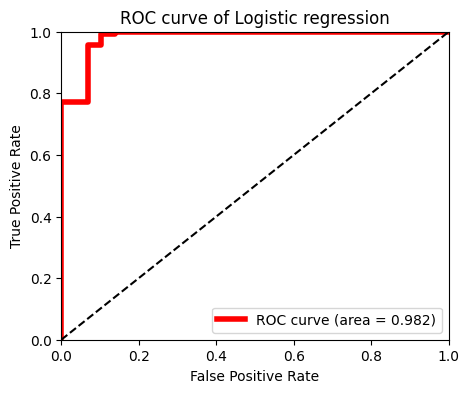

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# 훈련 데이터 셋, 테스트 데이터셋 분리
y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30) # 7대3으로 분리
print(x_train.shape)
print(x_test.shape)

# 학습
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:, 1]

# 성능 평가
print(f'accuracy_score :{accuracy_score(y_test, y_pred)}')
print(f'precision_score: {precision_score(y_test, y_pred)}')
print(f'recall_score: {recall_score(y_test, y_pred)}')
print(f'f1_score: {f1_score(y_test, y_pred)}')

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(f'confusion_matrix: {confmat}')


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)

plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') # 부정 리뷰
plt.ylabel('True Positive Rate') # 긍정 리뷰
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

- 전반적으로 예측 점수가 높게 나왔습니다. 근데 recall_score가 현실적으로 불가능한 1.0이 나왔습니다.
- confusion_matrix를 출력해서 확인해보니 긍정, 부정 값이 극단적으로 나왔습니다.
- 값을 적절히 섞어 샘플링 편향 문제를 해결해줘야 합니다.

In [112]:

# 긍정, 부정 값을 보니 긍정 값이 훨씬 많이
print(df['y'].value_counts())
# 1:1 비율로 랜덤 샘플링 수행
positive_random_idx = df[df['y']==1].sample(50, random_state=30).index.tolist() # 1인 리스트
negative_random_idx = df[df['y']==0].sample(50, random_state=30).index.tolist() # 0인 리스트
# 비율을 적절히 섞은 데이터로 데이터 셋을 나눔
# random_idx = positive_random_idx + negative_random_idx
# sample_X = X[random_idx, :]
# y = df['y'][random_idx]
# x_train, x_test, y_train, y_test = train_test_split(sample_X, y, test_size=0.30)

1    403
0    183
Name: y, dtype: int64


## 중요 키워드 분석
- 회귀 모델의 피쳐 영향력 추출
- 중요 피쳐의 형태소


[(1.3132392296234547, 495), (0.9196748105959864, 636), (0.8885623335056131, 681), (0.8717313811544807, 673), (0.6999362305243667, 581)]
[(-1.0507422177057975, 1425), (-1.0707172073762092, 1730), (-1.1980039964937252, 607), (-1.725896123432721, 930), (-1.8446574776119524, 1428)]


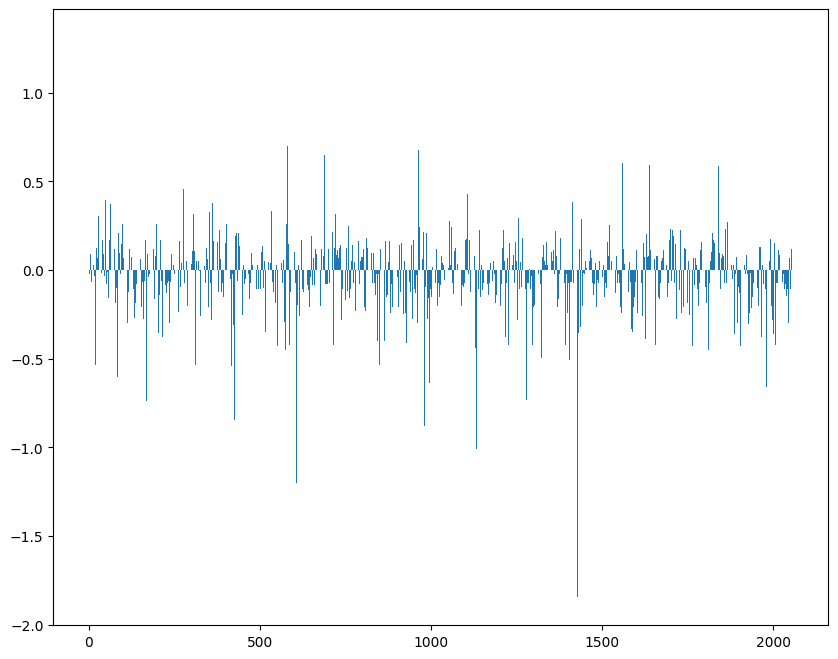

In [114]:
# 학습한 회귀 모델의 계수를 출력
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

In [117]:
# 중요 피쳐의 형태소

# 회귀 모델의 계수를 높은 순으로 정렬
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)
# 회귀 모델의 계수를 index_vectorizer에 맵핑하여, 어떤 형태소인지 출력할 수 있게 함
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로, 피처에 형태소를 맵핑한 결과를 출력. 계수가 높은 피처는 리뷰에 긍정적인 영향을 주는 형태소라고 할 수 있음.
print(str(invert_index_vectorizer)[:100]+'..')

print()

# 상위 20개 긍정 형태소를 출력
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

print()

# 상위 20개 부정 형태소를 출력
for coef in coef_pos_index[-20:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

{687: '맛있었어요/Adjective', 1847: '콩나물/Noun', 1274: '엄청/Adverb', 1650: '좋아해서/Adjective', 656: '많이/Adver..

도/Josa 1.3132392296234547
만두/Noun 0.9196748105959864
맛있어요/Adjective 0.8885623335056131
맛있고/Adjective 0.8717313811544807
또/Noun 0.6999362305243667
존맛/Noun 0.6978380376082869
맛있습니다/Adjective 0.6831902523993485
빵/Noun 0.675085955258159
맛있음/Adjective 0.6481108079788003
양도/Noun 0.6237661835649124
군/Noun 0.6218441424786076
장소/Noun 0.6053836264971174
좋고/Adjective 0.5950213039971219
많고/Adjective 0.5911890212993616
커피/Noun 0.5869263655166895
맛있게/Adjective 0.5641974795621152
맛집/Noun 0.5527960046703568
가보세요/Verb 0.5252474691250691
맛있네요/Adjective 0.49794659065448493
엄청/Adverb 0.49411266769434725

없는/Adjective -0.7332440542625409
곳/Noun -0.7357080254898932
안/VerbPrefix -0.7540537007432838
않은/Verb -0.7693175580426705
지점/Noun -0.7772839751353118
합니다/Verb -0.8260247871067637
다시/Noun -0.8426768194285366
곱창/Noun -0.8554506035257465
집/Noun -0.8602555645586689
일본/Noun -0.875996449157618
산/Noun -0.875996